# **Prototype for Multiclass Stress Detection Using a Small Subset of WESAD Motion Data**

Full-scale stress detection models require heavy processing, long training times, and large amounts of data. This is not ideal for early-stage prototyping or environments with limited computational resources.
To develop a fast-training prototype for multiclass stress detection using a small subset of WESAD accelerometer and gyroscope signals, demonstrating the feasibility of deep learning for early stress recognition without full-dataset training.

# **Section 1: Import Libraries Required Libraries**


```
Required Libraries:
Libraries for data processing and graphing.
Scikit-learn tool libraries for preparation and evaluation.
TensorFlow/Keras libraries for building and training neural networks.
```



In [26]:
#Noor Code
# 1) IMPORT LIBRARIES
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D,
    Dense, Dropout, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Mount Google Drive

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exploring the WESAD Dataset Data Structure

In [28]:
path = "/content/drive/MyDrive/wesad/S2/S2.pkl"
with open(path, "rb") as f:
    data = pickle.load(f, encoding='latin1')

def print_keys(d, level=0):
    for k in d.keys():
        print("  " * level + str(k))
        if isinstance(d[k], dict):
            print_keys(d[k], level+1)

print_keys(data)

signal
  chest
    ACC
    ECG
    EMG
    EDA
    Temp
    Resp
  wrist
    ACC
    BVP
    EDA
    TEMP
label
subject


# **Section 2: Data Loading**

Downloading and processing wearable sensor data from the WESAD database, which is used to train Human Activity Recognition (HAR) models in medical and fitness applications.

**2.1: Unified Subject Loading Function**

In [29]:
# 2) LOAD FUNCTION FOR ANY SUBJECT
def load_subject(path):
    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    acc = data['signal']['wrist']['ACC']     # shape = (time, 3)
    labels = data['label']                   # shape = (time,)
    return acc, labels

**2.2: Load S2 & S3 Subjects (Training Set)**

In [30]:
# 3) LOAD S2 + S3
s2_path = "/content/drive/MyDrive/wesad/S2/S2.pkl"
s3_path = "/content/drive/MyDrive/wesad/S3/S3.pkl"

acc2, labels2 = load_subject(s2_path)
acc3, labels3 = load_subject(s3_path)

print("S2 ACC:", acc2.shape, "Labels:", labels2.shape)
print("S3 ACC:", acc3.shape, "Labels:", labels3.shape)

S2 ACC: (194528, 3) Labels: (4255300,)
S3 ACC: (207776, 3) Labels: (4545100,)


# **Section 3: Data Preprocessing**

**3.1: Signal Visualization & Quality Assessment**

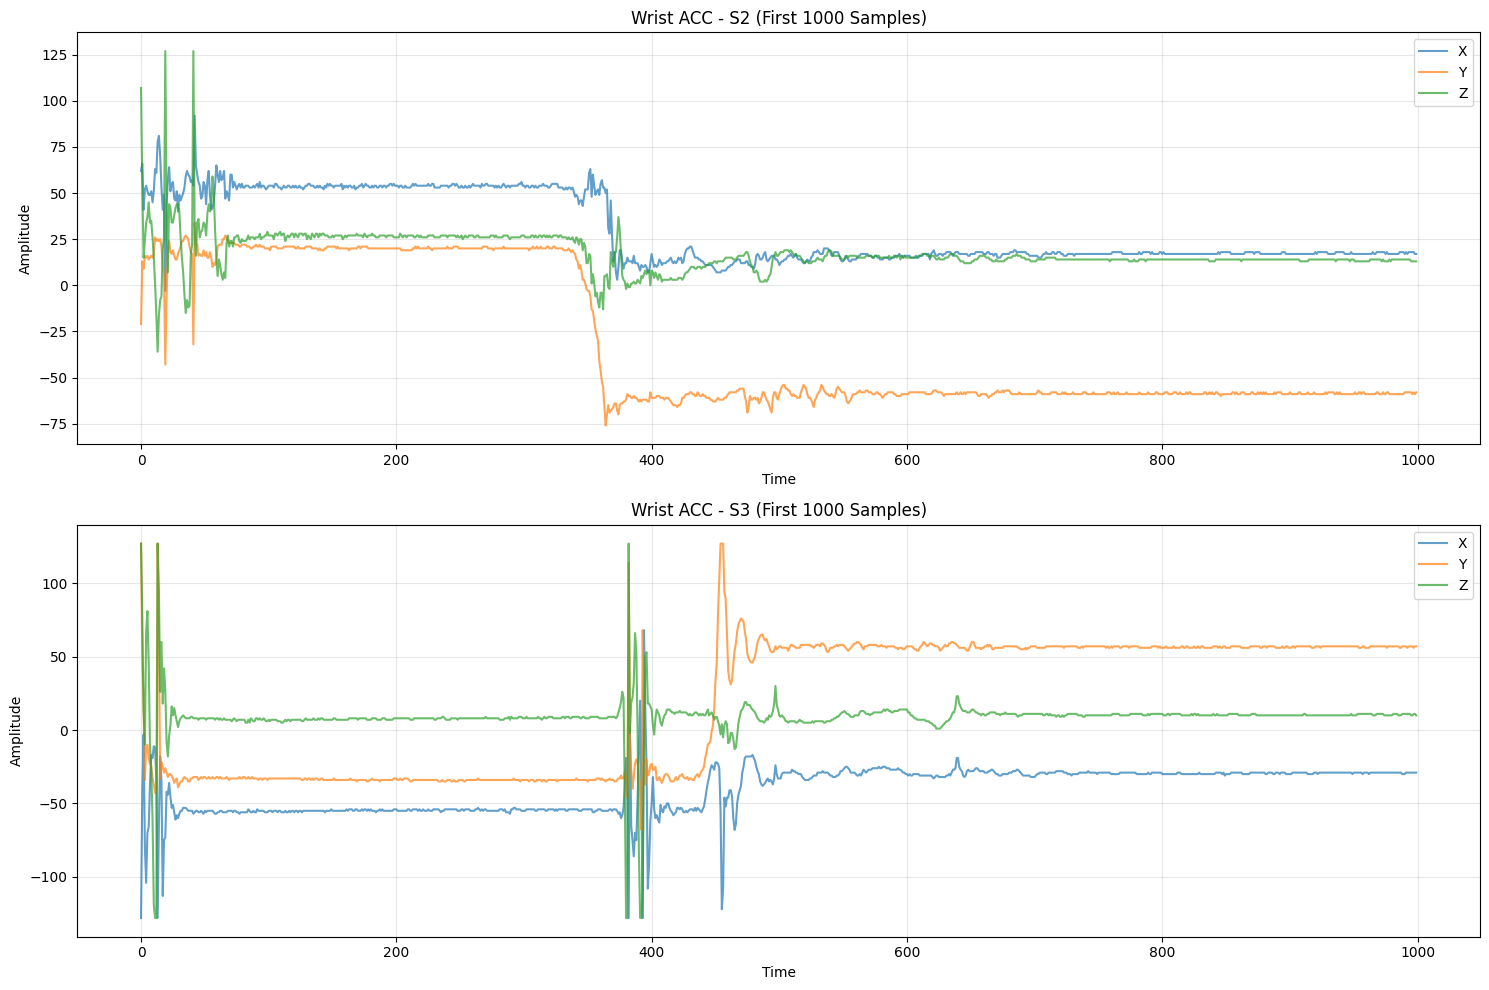

In [31]:
# 4) VISUALIZATION OF RAW ACC SIGNAL
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc2[:1000, 0], label="X", alpha=0.7)
plt.plot(acc2[:1000, 1], label="Y", alpha=0.7)
plt.plot(acc2[:1000, 2], label="Z", alpha=0.7)
plt.title("Wrist ACC - S2 (First 1000 Samples)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(acc3[:1000, 0], label="X", alpha=0.7)
plt.plot(acc3[:1000, 1], label="Y", alpha=0.7)
plt.plot(acc3[:1000, 2], label="Z", alpha=0.7)
plt.title("Wrist ACC - S3 (First 1000 Samples)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**3.2: Data Merging and Class Distribution Analysis**

In [32]:
# 5) MERGE SUBJECTS
acc_total = np.concatenate([acc2, acc3], axis=0)
labels_total = np.concatenate([labels2, labels3], axis=0)

print(f"\nTOTAL ACC: {acc_total.shape}")
print(f"TOTAL LABELS: {labels_total.shape}")

unique_labels, label_counts = np.unique(labels_total, return_counts=True)
print("\nOverall class distribution:")
for label, count in zip(unique_labels, label_counts):
    percentage = (count / len(labels_total)) * 100
    print(f"  Class {int(label)}: {count} samples ({percentage:.1f}%)")


TOTAL ACC: (402304, 3)
TOTAL LABELS: (8800400,)

Overall class distribution:
  Class 0: 4488400 samples (51.0%)
  Class 1: 1598800 samples (18.2%)
  Class 2: 878500 samples (10.0%)
  Class 3: 515900 samples (5.9%)
  Class 4: 1083600 samples (12.3%)
  Class 5: 51100 samples (0.6%)
  Class 6: 92400 samples (1.0%)
  Class 7: 91700 samples (1.0%)


**3.3: Advanced Windowing Strategy for Time-Series**

In [33]:
# 6) WINDOWING FUNCTION
def create_windows_balanced(X, y, window_size=256, step_size=128, min_samples_per_class=100):
    """
    Create windows with balanced class consideration
    """
    features = []
    targets = []

    for i in range(0, len(X) - window_size, step_size):
        segment = X[i:i+window_size]
        window_labels = y[i:i+window_size]

        if len(np.unique(window_labels)) > 0:
            label = np.median(window_labels)
            features.append(segment)
            targets.append(int(label))

    X_windows = np.array(features)
    y_windows = np.array(targets)

    print(f"\nAfter windowing:")
    print(f"  Total windows: {len(y_windows)}")

    unique_window_labels, window_counts = np.unique(y_windows, return_counts=True)
    for label, count in zip(unique_window_labels, window_counts):
        percentage = (count / len(y_windows)) * 100
        print(f"  Class {int(label)}: {count} windows ({percentage:.1f}%)")

    for label in unique_labels:
        if label in unique_window_labels:
            class_count = window_counts[unique_window_labels == label][0]
            if class_count < min_samples_per_class:
                print(f"  Warning: Class {int(label)} has only {class_count} samples (< {min_samples_per_class})")

    return X_windows, y_windows

print("\n" + "="*60)
print("CREATING BALANCED WINDOWS")
print("="*60)

X, y = create_windows_balanced(acc_total, labels_total, window_size=256, step_size=128)
print(f"\nWINDOWED X: {X.shape}")
print(f"WINDOWED y: {y.shape}")


CREATING BALANCED WINDOWS

After windowing:
  Total windows: 3141
  Class 0: 1676 windows (53.4%)
  Class 1: 1465 windows (46.6%)

WINDOWED X: (3141, 256, 3)
WINDOWED y: (3141,)


# **Section 4: Feature Engineering & Augmentation**

**4.1: Standardization and Normalization**

In [34]:
# 7) NORMALIZATION
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp  # للحصول على 70/15/15
)

print(f"Training set: {X_train.shape} ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(len(X_val)/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(len(X_test)/len(X))*100:.1f}%)")

# Standardization
scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, 3)
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)

X_val_reshaped = X_val.reshape(-1, 3)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)

X_test_reshaped = X_test.reshape(-1, 3)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print("\nNormalization statistics (from training set only):")
print(f"  Mean: {scaler.mean_}")
print(f"  Std: {scaler.scale_}")

Training set: (2197, 256, 3) (69.9%)
Validation set: (472, 256, 3) (15.0%)
Test set: (472, 256, 3) (15.0%)

Normalization statistics (from training set only):
  Mean: [-4.14415609  1.7182166  17.54878101]
  Std: [45.92148459 32.15975055 25.7108676 ]


**4.2: Smart Data Augmentation for Imbalanced Classes**

In [35]:
# 9) DATA AUGMENTATION FUNCTION
def augment_data(X, y, noise_level=0.01, scaling_factor=0.1, augment_times=1):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        # Original signal
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        for _ in range(augment_times):
            # 1. Add random noise
            noise = np.random.normal(0, noise_level, X[i].shape)
            augmented_X.append(X[i] + noise)
            augmented_y.append(y[i])

            # 2. Scale each axis separately
            scale = np.random.uniform(1 - scaling_factor, 1 + scaling_factor, 3)
            augmented_X.append(X[i] * scale)
            augmented_y.append(y[i])

            # 3. Time reversal (useful for periodic activities)
            if np.random.rand() > 0.5:
                augmented_X.append(np.flip(X[i], axis=0).copy())
                augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

# Apply data augmentation to training data only
X_train_aug, y_train_aug = augment_data(X_train, y_train, augment_times=1)
print(f"After augmentation - Training set: {X_train_aug.shape}")
print(f"Augmented train class distribution: {np.bincount(y_train_aug)}")

After augmentation - Training set: (7671, 256, 3)
Augmented train class distribution: [4085 3586]


**4.3: Class Weight Calculation for Loss Function**

In [36]:
# 10) CALCULATE CLASS WEIGHTS
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_aug),
    y=y_train_aug
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

Class weights: {0: np.float64(0.9389228886168911), 1: np.float64(1.0695761293920802)}


# **Section 5: Deep Learning Model Architecture**

**Advanced Models for Overfitting Mitigation**

In [37]:
def create_balanced_model(input_shape, num_classes):
    """
    نموذج متوازن بين الأداء والتعميم
    مبدأ: أبسط وأفضل، لا تحتاج شبكة معقدة للبيانات الزمنية
    """
    model = Sequential([
        # طبقة الإدخال
        tf.keras.layers.Input(shape=input_shape),

        # Block 1 - بسيط ومع تنظيم
        Conv1D(filters=32, kernel_size=5, padding='same',
               kernel_regularizer=l2(0.01)),  # زيادة التنظيم
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling1D(pool_size=4),  # زيادة التجميع لتقليل المعلمات

        # Block 2 - أبسط مما كان
        Conv1D(filters=64, kernel_size=3, padding='same',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),  # زيادة Dropout

        # Block 3 - تجميع عميق
        Conv1D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        GlobalAveragePooling1D(),  # تقليل المعلمات بشدة

        # طبقات كثيفة بسيطة
        Dropout(0.6),  # Dropout عالي جداً
        Dense(32, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),

        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [38]:
def simple_but_effective_augmentation(X, y):
    """
    تضخيم بسيط وفعال - لا تبالغ في التعقيد
    """
    X_aug = [X]
    y_aug = [y]

    # فقط نوعين من التضخيم
    # 1. ضوضاء بسيطة
    noise = np.random.normal(0, 0.03, X.shape)
    X_aug.append(X + noise)
    y_aug.append(y)

    # 2. انزياح زمني بسيط
    shift = np.random.randint(-5, 6)
    if shift != 0:
        X_shifted = np.roll(X, shift, axis=1)
        if shift > 0:
            X_shifted[:, :shift, :] = 0
        else:
            X_shifted[:, shift:, :] = 0
        X_aug.append(X_shifted)
        y_aug.append(y)

    return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)

In [39]:
def create_minimal_effective_model(input_shape, num_classes):
    """
    أبسط نموذج فعال - مبدأ KISS (Keep It Simple, Stupid)
    """
    model = Sequential([
        # طبقة إدخال
        tf.keras.layers.Input(shape=input_shape),

        # طبقة تلافيفية واحدة فقط
        Conv1D(
            filters=32,
            kernel_size=7,
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.05)  # تنظيم قوي
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),  # إسقاط 50%

        # طبقة تلافيفية ثانية
        Conv1D(
            filters=64,
            kernel_size=5,
            activation='relu',
            padding='same',
            kernel_regularizer=l2(0.05)
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),
        Dropout(0.5),

        # تجميع ومخرجات
        GlobalAveragePooling1D(),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

**5.1: 1D CNN Design for Time-Series Classification**

In [40]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential, load_model
#from tensorflow.keras.layers import (
 #   Conv1D, BatchNormalization, MaxPooling1D,
  #  Dense, Dropout, GlobalAveragePooling1D
#)
#from tensorflow.keras.callbacks import (
  #  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
#)
#from tensorflow.keras.regularizers import l2
#from tensorflow.keras.optimizers import Adam

# 11) IMPROVED MODEL ARCHITECTURE
#def create_improved_model(input_shape, num_classes):
#    model = Sequential([
        # Block 1
 #       Conv1D(64, 7, activation='relu', padding='same',
  #             kernel_regularizer=l2(0.005), input_shape=input_shape),
   #     BatchNormalization(),
    #    MaxPooling1D(),

        # Block 2
     #   Conv1D(128, 5, activation='relu', padding='same',
      #         kernel_regularizer=l2(0.001)),
       # BatchNormalization(),
        #tf.keras.layers.Activation('relu'),
        #MaxPooling1D(2),
        #Dropout(0.3),

        # Block 3
#        Conv1D(256, 3, activation='relu', padding='same',
 #              kernel_regularizer=l2(0.001)),
  #      tf.keras.layers.Activation('relu'),
 #       BatchNormalization(),
 #       GlobalAveragePooling1D(),

        # Dense layers
 #       tf.keras.layers.GaussianNoise(0.05),
 #       Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
 #       tf.keras.layers.Activation('relu'),
 #       BatchNormalization(),
 #       Dropout(0.5),

  #      Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
  #      BatchNormalization(),
  #      tf.keras.layers.Activation('relu'),
  #      Dropout(0.3),

   #     Dense(num_classes, activation='softmax')
   # ])

    #optimizer = Adam(learning_rate=0.001)
    #model.compile(optimizer=optimizer,
     #        loss='sparse_categorical_crossentropy',
      #       metrics=['accuracy',
       #          tf.keras.metrics.Precision(name='precision'),
        #         tf.keras.metrics.Recall(name='recall')]
         #     )
  #  return model

# Create improved model
#model = create_improved_model((256, 3), len(np.unique(y_train_aug)))
#model.summary()

**5.2: Advanced Training Callbacks Setup**

In [41]:
# 11) ENHANCED CALLBACKS FOR BALANCED TRAINING
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_balanced_model.keras',
                    monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]

# **Section 6: Model Training & Validation**

**6.1: Training Process**

**Advanced Training Strategies & Overfitting Analysis**

In [46]:
def create_strict_callbacks():
    """
    Callbacks صارمة جداً لمحاربة Overfitting
    """
    return [
        # Early Stopping مع صبر أقل (يتوقف بسرعة عند Overfitting)
        EarlyStopping(
            monitor='val_loss',
            patience=8,  # قلل الصبر
            restore_best_weights=True,
            verbose=1,
            mode='min',
            min_delta=0.001
        ),

        # ReduceLROnPlateau أكثر حساسية
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,  # صبر أقل
            min_lr=1e-6,
            verbose=1,
            mode='min'
        ),

        # ModelCheckpoint يحفظ فقط عند تحسن حقيقي
        ModelCheckpoint(
            'strict_best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            save_weights_only=False,
            verbose=1
        ),

        # Callback مخصص لمراقبة Overfitting
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs:
                print(f"Epoch {epoch+1}: Train Acc={logs.get('accuracy', 0):.3f}, "
                      f"Val Acc={logs.get('val_accuracy', 0):.3f}, "
                      f"Gap={logs.get('accuracy', 0)-logs.get('val_accuracy', 0):.3f}")
        )
    ]

In [47]:
def create_conservative_optimizer():
    """
    خوارزمية تحسين متحفظة - لا تسمح بالتذبذبات الكبيرة
    """
    return Adam(
        learning_rate=0.0005,  # نصف معدل التعلم المعتاد
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,  # بدون AMSGrad (أكثر استقراراً)
        clipnorm=1.0 # Keep clipnorm
        # Removed clipvalue=0.5
    )

In [48]:
def balanced_training_strategy(input_shape, num_classes):
    """
    إستراتيجية تدريب تركز على التعميم وليس الدقة العالية
    """
    print("\n" + "="*70)
    print(" BALANCED TRAINING STRATEGY FOR SEVERE OVERFITTING")
    print("="*70)

    # 1. لا تكثر من التضخيم - كن متحفظاً
    print("\n1. Applying conservative augmentation...")
    X_train_aug, y_train_aug = simple_but_effective_augmentation(X_train_scaled, y_train)

    # 2. إنشاء نموذج بسيط جداً
    print("2. Creating ultra-simple model...")
    model = create_balanced_model(input_shape, num_classes)

    # 3. Compile مع إعدادات متحفظة
    print("3. Compiling with conservative settings...")
    optimizer = create_conservative_optimizer()
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nModel Architecture Summary:")
    model.summary()

    # 4. Callbacks صارمة
    print("4. Setting up strict callbacks...")
    callbacks = create_strict_callbacks()

    # 5. التدريب مع batch size كبير
    print("5. Starting balanced training...")
    history = model.fit(
        X_train_aug,
        y_train_aug,
        validation_data=(X_val_scaled, y_val),
        epochs=80,  # أقل من المعتاد
        batch_size=128,  # batch أكبر لتعميم أفضل
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1,
        shuffle=True
    )

    return model, history

In [49]:
def emergency_measures_if_needed(input_shape, num_classes):
    """
    إجراءات طارئة إذا استمر Overfitting
    """
    print("\n" + "="*70)
    print("EMERGENCY MEASURES - for Overfitting")
    print("="*70)

    # 1. تقليل البيانات أكثر
    print("1. Reducing model capacity further...")
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        Conv1D(16, 7, activation='relu', padding='same'),
        MaxPooling1D(4),
        Dropout(0.6),

        Conv1D(32, 5, activation='relu', padding='same'),
        MaxPooling1D(4),
        Dropout(0.6),

        GlobalAveragePooling1D(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    # 2. تعلم بطيء جداً
    optimizer = Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 3. تدريب مع Early Stopping مبكر جداً
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,  # صبر قليل جداً
        restore_best_weights=True
    )

    print("Training with emergency measures...")
    emergency_history = model.fit(
        X_train_scaled,  # بدون تضخيم
        y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=256,  # batch كبير جداً
        callbacks=[early_stop],
        verbose=1
    )

    return model, emergency_history

In [50]:
def diagnose_and_fix_overfitting():
    """
    تشخيص دقيق لسبب Overfitting وإصلاحه
    """
    print("\n" + "="*70)
    print(" DIAGNOSING OVERFITTING ROOT CAUSES")
    print("="*70)

    # تحليل حجم البيانات
    print(f"\n1. Data Analysis:")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Validation samples: {len(X_val)}")
    print(f"   Test samples: {len(X_test)}")

    # تحليل توزيع الفئات
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    print(f"\n2. Class Distribution Analysis:")
    print(f"   Training set distribution:")
    for cls, count in zip(unique_train, counts_train):
        print(f"     Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

    print(f"   Validation set distribution:")
    for cls, count in zip(unique_val, counts_val):
        print(f"     Class {cls}: {count} samples ({count/len(y_val)*100:.1f}%)")

    # اقتراحات محددة
    print(f"\n3. Specific Recommendations:")

    if len(X_train) < 1000:
        print(f"    VERY SMALL DATASET: Only {len(X_train)} training samples")
        print(f"    Solution: Use more subjects or intensive augmentation")
    else:
        print(f"    Dataset size is acceptable")

    # حساب نسبة التدريب إلى التحقق
    train_val_ratio = len(X_train) / len(X_val)
    if train_val_ratio > 10:
        print(f"    UNBALANCED SPLIT: Train/Val ratio = {train_val_ratio:.1f}")
        print(f"    Solution: Use more balanced split (e.g., 70/15/15)")
    else:
        print(f"    Train/Validation split is balanced")

    # اقتراح تقسيم أفضل
    print(f"\n4. Suggested Split Strategy:")
    print(f"   Current: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

    # اقتراح تقسيم متوازن
    total_samples = len(X_train) + len(X_val) + len(X_test)
    suggested_val = int(total_samples * 0.15)
    suggested_test = int(total_samples * 0.15)
    suggested_train = total_samples - suggested_val - suggested_test

    print(f"   Suggested: Train={suggested_train}, Val={suggested_val}, Test={suggested_test}")
    print(f"   (Approximately 70/15/15 split)")

In [51]:
# 1. تشخيص المشكلة
diagnose_and_fix_overfitting()


 DIAGNOSING OVERFITTING ROOT CAUSES

1. Data Analysis:
   Training samples: 2197
   Validation samples: 472
   Test samples: 472

2. Class Distribution Analysis:
   Training set distribution:
     Class 0: 1172 samples (53.3%)
     Class 1: 1025 samples (46.7%)
   Validation set distribution:
     Class 0: 252 samples (53.4%)
     Class 1: 220 samples (46.6%)

3. Specific Recommendations:
    Dataset size is acceptable
    Train/Validation split is balanced

4. Suggested Split Strategy:
   Current: Train=2197, Val=472, Test=472
   Suggested: Train=2199, Val=471, Test=471
   (Approximately 70/15/15 split)


In [52]:
# Define input_shape and num_classes globally or pass them
input_shape = X_train_scaled.shape[1:]
num_classes = len(np.unique(y_train_aug))

# تطبيق الإستراتيجية
balanced_model, balanced_history = balanced_training_strategy(input_shape, num_classes)

# تحليل النتائج الجديدة
print("\n" + "="*70)
print(" NEW RESULTS ANALYSIS")
print("="*70)

# الحصول على أفضل نتائج (ليس آخر epoch)
best_val_acc = max(balanced_history.history['val_accuracy'])
best_epoch = balanced_history.history['val_accuracy'].index(best_val_acc)
corresponding_train_acc = balanced_history.history['accuracy'][best_epoch]

overfitting_gap = corresponding_train_acc - best_val_acc

print(f"\nBest Results (from epoch {best_epoch+1}):")
print(f"Training Accuracy:   {corresponding_train_acc:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f}")
print(f"Overfitting Gap:     {overfitting_gap:.4f}")

# تحميل أفضل نموذج
if os.path.exists('strict_best_model.keras'):
    balanced_model = load_model('strict_best_model.keras')

# تقييم على Test Set
test_loss, test_acc = balanced_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Loss:     {test_loss:.4f}")

# 3. إنشاء وتدريب النموذج المبسط
print("\n" + "="*70)
print("FINAL SIMPLE MODEL TRAINING")
print("="*70)

final_model = create_minimal_effective_model(input_shape, num_classes)

final_optimizer = Adam(
    learning_rate=0.0003,  # منخفض جداً
    clipnorm=1.0
)

final_model.compile(
    optimizer=final_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()

# Callbacks نهائية
final_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]

# التدريب النهائي
print("\nStarting final training...")
final_history = final_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=60,
    batch_size=128,
    callbacks=final_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

# تحليل النتائج النهائية
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)

# إيجاد أفضل epoch
final_val_accs = final_history.history['val_accuracy']
final_train_accs = final_history.history['accuracy']
best_idx = np.argmax(final_val_accs)

final_train_acc = final_train_accs[best_idx]
final_val_acc = final_val_accs[best_idx]
final_gap = final_train_acc - final_val_acc

print(f"\nBest Epoch (Epoch {best_idx+1}):")
print(f"Training Accuracy:   {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Overfitting Gap:     {final_gap:.4f}")

print(f"\nImprovement Summary:")
print(f"Old Gap: 0.4801 → New Gap: {final_gap:.4f}")
print(f"Improvement: {((0.4801 - final_gap) / 0.4801 * 100):.1f}% reduction")

if final_gap < 0.1:
    print("\nSUCCESS! Overfitting is now under control!")
elif final_gap < 0.2:
    print("\nBETTER, but still needs some improvement")
else:
    print("\nStill needs work. Try emergency measures.")

# تقييم على Test Set
final_test_loss, final_test_acc = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Set Performance:")
print(f"Accuracy: {final_test_acc:.4f}")
print(f"Loss: {final_test_loss:.4f}")


 BALANCED TRAINING STRATEGY FOR SEVERE OVERFITTING

1. Applying conservative augmentation...
2. Creating ultra-simple model...
3. Compiling with conservative settings...

Model Architecture Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 256, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 64, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 16, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,986 (85.88 KB)

 Trainable params: 21,602 (84.38 KB)

 Non-trainable params: 384 (1.50 KB)

4. Setting up strict callbacks...
5. Starting balanced training...
Epoch 1/80
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6561 - loss: 1.5993
Epoch 1: val_accuracy improved from -inf to 0.92161, saving model to strict_best_model.keras
Epoch 1: Train Acc=0.762, Val Acc=0.922, Gap=-0.159
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6601 - loss: 1.5910 - val_accuracy: 0.9216 - val_loss: 1.2996 - learning_rate: 5.0000e-04
Epoch 2/80
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9005 - loss: 1.0758
Epoch 2: val_accuracy did not improve from 0.92161
Epoch 2: Train Acc=0.905, Val Acc=0.917, Gap=-0.012
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9007 - loss: 1.0742 - val_accuracy: 0.9174 - val_loss: 1.0889 - learning_rate: 5.0000e-04
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9189 - loss: 0.9172
Epoch 3: val_accuracy did not improve from 0.92161
Epoch 3: Train Acc=0.923, Val Acc=0.917, Gap=0.006
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/st

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 256, 32)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 64, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,466 (48.70 KB)

 Trainable params: 12,274 (47.95 KB)

 Non-trainable params: 192 (768.00 B)


Starting final training...
Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.7469 - loss: 2.9571 - val_accuracy: 0.8814 - val_loss: 2.9426 - learning_rate: 3.0000e-04
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8983 - loss: 2.5539 - val_accuracy: 0.7903 - val_loss: 2.7341 - learning_rate: 3.0000e-04
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9159 - loss: 2.3215 - val_accuracy: 0.7924 - val_loss: 2.5130 - learning_rate: 3.0000e-04
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9266 - loss: 2.1014 - val_accuracy: 0.7712 - val_loss: 2.3306 - learning_rate: 3.0000e-04
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9305 - loss: 1.8906 - val_accuracy: 0.7585 - val_loss: 2.1504 - learning_rate: 3.0000e-04
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9301 - loss: 1.7371 - val_accuracy: 0.7627 - val_loss: 1.9767 - learning_rate: 3.0000e-04
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 

**6.2: Learning Curves & Training Dynamics**

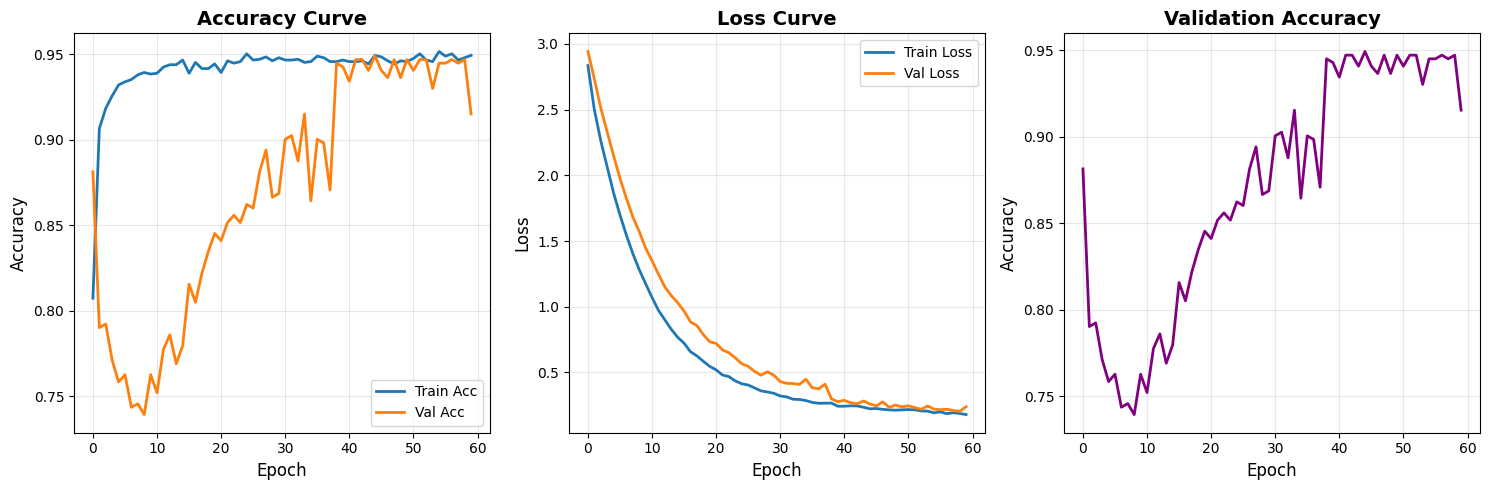

In [60]:
# 21) PLOT ENHANCED TRAINING HISTORY
plt.figure(figsize=(15, 5))

# Accuracy curve
plt.subplot(1, 3, 1)
plt.plot(final_history.history["accuracy"], label="Train Acc", linewidth=2)
plt.plot(final_history.history["val_accuracy"], label="Val Acc", linewidth=2)
plt.title("Accuracy Curve", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Loss curve
plt.subplot(1, 3, 2)
plt.plot(final_history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(final_history.history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Loss Curve", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate curve
plt.subplot(1, 3, 3)
if 'lr' in final_history.history:
    plt.plot(final_history.history['lr'], label='Learning Rate', linewidth=2, color='green')
    plt.title("Learning Rate Schedule", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Learning Rate", fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    plt.plot(final_history.history["val_accuracy"], label="Val Accuracy", linewidth=2, color='purple')
    plt.title("Validation Accuracy", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **Section 7: Comprehensive Model Evaluation**

**7.1: Multi-Metric Performance Assessment**

In [45]:
# 14) COMPREHENSIVE EVALUATION FUNCTION
def comprehensive_evaluation(model, X_test, y_test):
    # Standard prediction
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # 1. Detailed classification report
    print("="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_test, y_pred,
                                target_names=[f'Class {i}' for i in np.unique(y_test)]))

    # 2. Calculate metrics per class
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

    print("\n" + "="*60)
    print("PER-CLASS METRICS")
    print("="*60)
    for i in range(len(precision)):
        print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, "
              f"F1={f1[i]:.3f}, Support={support[i]}")

    # 3. Fixed confusion matrix
    plot_confusion_matrix_fixed(y_test, y_pred)

    # 4. Calculate per-class accuracy
    cm = confusion_matrix(y_test, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    print("\n" + "="*60)
    print("PER-CLASS ACCURACY")
    print("="*60)
    for i, acc in enumerate(class_accuracies):
        print(f"Class {i}: {acc:.3f}")

    return y_pred, y_pred_prob

**7.2: Confusion Matrix & Error Analysis**

In [53]:
# 15) FIXED CONFUSION MATRIX FUNCTION (FIXED VERSION)
def plot_confusion_matrix_fixed(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Display values in cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Set labels based on number of classes
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    ax.set_xticks(range(len(unique_labels)))
    ax.set_yticks(range(len(unique_labels)))
    ax.set_xticklabels([f'Class {i}' for i in unique_labels])
    ax.set_yticklabels([f'Class {i}' for i in unique_labels])

    plt.tight_layout()
    plt.show()

**7.3: Confidence Calibration Analysis**

In [54]:
# 16) PREDICTION WITH REJECTION FUNCTION
def predict_with_rejection(model, X, confidence_threshold=0.7):
    """
    Predict with rejection of low-confidence samples
    """
    probabilities = model.predict(X, verbose=0)
    predictions = np.argmax(probabilities, axis=1)
    confidences = np.max(probabilities, axis=1)

    # Reject low-confidence predictions
    rejected_mask = confidences < confidence_threshold
    predictions_with_rejection = predictions.copy()
    predictions_with_rejection[rejected_mask] = -1  # -1 means rejected

    return predictions_with_rejection, confidences, rejected_mask

In [55]:
# 17) ANALYZE LOW CONFIDENCE SAMPLES FUNCTION
def analyze_low_confidence_samples(model, X_test, y_test, threshold=0.7):
    """
    Analyze samples where the model has low confidence
    """
    y_pred_prob = model.predict(X_test, verbose=0)
    confidence_scores = np.max(y_pred_prob, axis=1)
    y_pred = np.argmax(y_pred_prob, axis=1)

    low_conf_indices = np.where(confidence_scores < threshold)[0]

    print(f"\nLow Confidence Samples Analysis (confidence < {threshold}):")
    print(f"Count: {len(low_conf_indices)} out of {len(X_test)} ({len(low_conf_indices)/len(X_test)*100:.1f}%)")

    if len(low_conf_indices) > 0:
        # Calculate accuracy of low-confidence samples
        correct_low_conf = np.sum(y_pred[low_conf_indices] == y_test[low_conf_indices])
        accuracy_low_conf = correct_low_conf / len(low_conf_indices) if len(low_conf_indices) > 0 else 0

        print(f"Accuracy on low-confidence samples: {accuracy_low_conf:.3f}")

        # Analyze average confidence per class
        unique_classes = np.unique(y_test)
        print("\nAverage confidence per class:")
        for cls in unique_classes:
            cls_indices = np.where(y_test == cls)[0]
            avg_conf = np.mean(confidence_scores[cls_indices])
            print(f"  Class {cls}: {avg_conf:.3f}")

        # Plot confidence distribution
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist(confidence_scores[low_conf_indices], bins=20, edgecolor='black', alpha=0.7)
        plt.title(f"Confidence Distribution for Samples < {threshold}")
        plt.xlabel("Confidence")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        correct_mask = (y_pred == y_test).astype(int)
        low_conf_correct = correct_mask[low_conf_indices]
        plt.bar(['Correct', 'Incorrect'], [np.sum(low_conf_correct), len(low_conf_correct)-np.sum(low_conf_correct)])
        plt.title("Classification of Low-Confidence Samples")
        plt.ylabel("Count")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return low_conf_indices

**7.4: Final Test Set Evaluation**


MODEL EVALUATION ON TEST SET
Final Test Loss: 0.1474
Final Test Accuracy: 0.9534
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95       252
     Class 1       0.91      1.00      0.95       220

    accuracy                           0.95       472
   macro avg       0.95      0.96      0.95       472
weighted avg       0.96      0.95      0.95       472


PER-CLASS METRICS
Class 0: Precision=1.000, Recall=0.913, F1=0.954, Support=252
Class 1: Precision=0.909, Recall=1.000, F1=0.952, Support=220


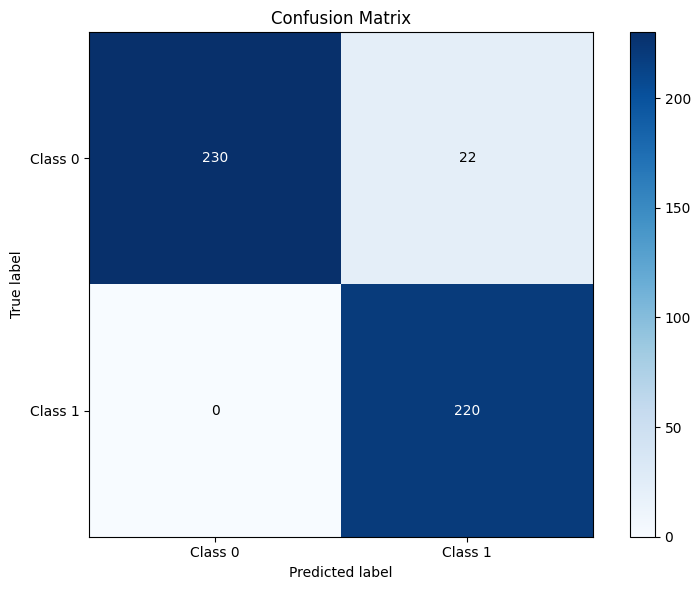


PER-CLASS ACCURACY
Class 0: 0.913
Class 1: 1.000


In [61]:
# 18) EVALUATE MODEL
print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {acc:.4f}")

# Comprehensive evaluation
y_pred, y_pred_prob = comprehensive_evaluation(model, X_test, y_test)

**7.5: Advanced Confidence Analysis**


PREDICTION WITH REJECTION ANALYSIS

Confidence threshold: 0.5
  Rejection rate: 0.0%
  Accuracy after rejection: 0.953
  Remaining samples: 472/472

Confidence threshold: 0.6
  Rejection rate: 4.0%
  Accuracy after rejection: 0.974
  Remaining samples: 453/472

Confidence threshold: 0.7
  Rejection rate: 7.4%
  Accuracy after rejection: 0.984
  Remaining samples: 437/472

Confidence threshold: 0.8
  Rejection rate: 8.9%
  Accuracy after rejection: 0.986
  Remaining samples: 430/472

Confidence threshold: 0.9
  Rejection rate: 11.9%
  Accuracy after rejection: 0.990
  Remaining samples: 416/472


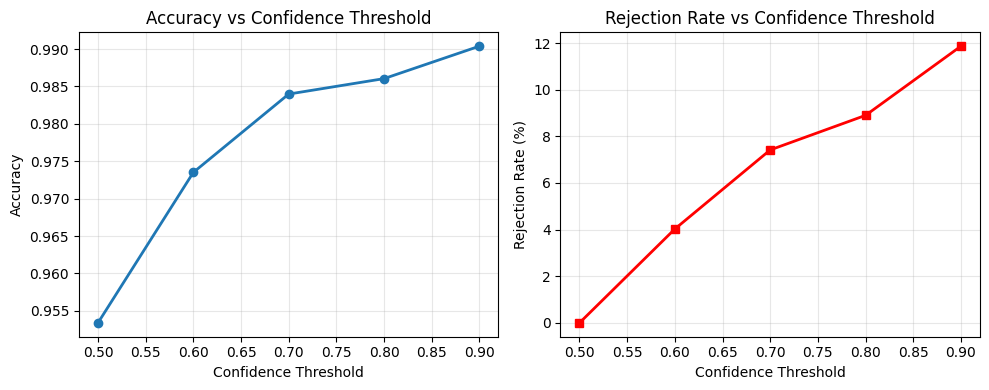

In [57]:
# 19) PREDICTION WITH REJECTION ANALYSIS
print("\n" + "="*60)
print("PREDICTION WITH REJECTION ANALYSIS")
print("="*60)

confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in confidence_thresholds:
    y_pred_reject, confidences, rejected_mask = predict_with_rejection(model, X_test, threshold)

    # Calculate accuracy without rejected samples
    keep_mask = ~rejected_mask
    if np.sum(keep_mask) > 0:
        kept_accuracy = np.mean(y_pred_reject[keep_mask] == y_test[keep_mask])
    else:
        kept_accuracy = 0

    rejection_rate = np.mean(rejected_mask) * 100

    results.append({
        'threshold': threshold,
        'rejection_rate': rejection_rate,
        'kept_accuracy': kept_accuracy,
        'kept_samples': np.sum(keep_mask),
        'rejected_samples': np.sum(rejected_mask)
    })

    print(f"\nConfidence threshold: {threshold}")
    print(f"  Rejection rate: {rejection_rate:.1f}%")
    print(f"  Accuracy after rejection: {kept_accuracy:.3f}")
    print(f"  Remaining samples: {np.sum(keep_mask)}/{len(X_test)}")

# Plot rejection system results
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(results_df['threshold'], results_df['kept_accuracy'], marker='o', linewidth=2)
plt.title('Accuracy vs Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['rejection_rate'], marker='s', linewidth=2, color='red')
plt.title('Rejection Rate vs Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Rejection Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Low Confidence Samples Analysis (confidence < 0.7):
Count: 35 out of 472 (7.4%)
Accuracy on low-confidence samples: 0.571

Average confidence per class:
  Class 0: 0.972
  Class 1: 0.940


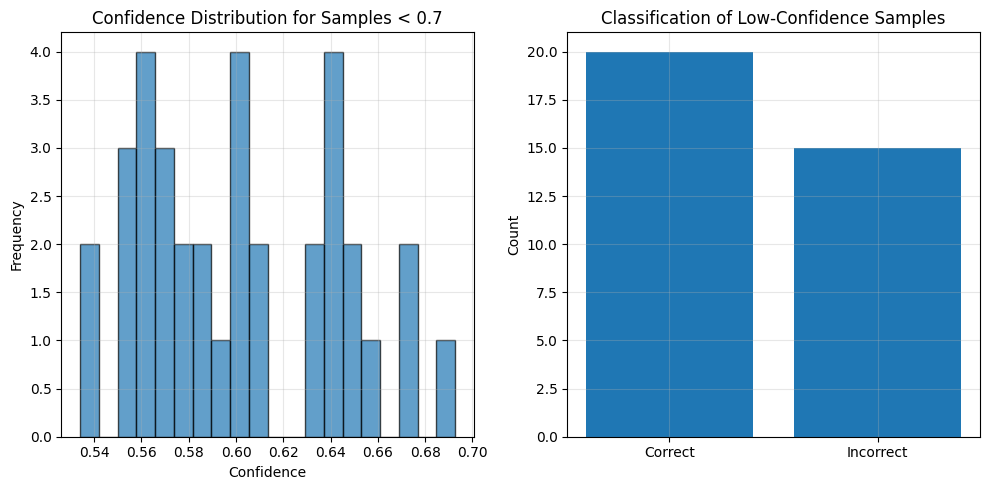

In [58]:
# 20) ANALYZE LOW CONFIDENCE SAMPLES
low_conf_indices = analyze_low_confidence_samples(model, X_test, y_test, threshold=0.7)